## Imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

from pathlib import Path

## Load Data and Inspect

In [56]:
pr_type_codes = {
  "1D": "Chapter 11 Bankruptcy Dismissed",
  "1F": "Chapter 11 Bankruptcy Filing",
  "1X": "Chapter 11 Bankruptcy Discharged",
  "2D": "Chapter 12 Bankruptcy Dismissed",
  "2F": "Chapter 12 Bankruptcy Filing",
  "2X": "Chapter 12 Bankruptcy Discharged",
  "3D": "Chapter 13 Bankruptcy Dismissed",
  "CJ": "Civil Judgment",
  "CP": "Child Support",
  "FC": "Foreclosure",
  "FT": "Federal Tax Lien",
  "JL": "Judicial Lien",
  "PC": "Paid Civil Jugment"
}

pr_source_type_codes = {
  "AS": "Associate Court",
  "BK": "U.S. Bankruptcy Court",
  "CA": "County Auditor",
  "CC": "County Clerk",
  "CI": "Circuit Court",
  "CL": "County Court at Law",
  "CN": "Conciliation Court",
  "CP": "Common Pleas",
  "CR": "County Recorder",
  "CT": "County Court",
  "CY": "City Court",
  "DC": "District Court",
  "FE": "Federal District",
  "JU": "Justice of the PeaceCourt type",
  "MA": "Magistrate Court",
  "MU": "Municipal Court",
  "PC": "Parish Court",
  "RD": "Recorder of Deeds",
  "SC": "Small Claims",
  "SU": "Superior Court"
}



In [57]:
pr = pd.read_csv('../Public_records.csv')

dtypes      = pr.dtypes
null_counts = pr.isna().sum()
distinct_obj = pr.select_dtypes(include="object").nunique(dropna=True)

print("Data Shape: ", pr.shape)


print(pd.concat({
    "dtype": dtypes,
    # "null_count": null_counts,
    "null_rate": round(100.0* null_counts / pr.shape[0]),
    "distinct_groups": distinct_obj
    },
    axis = 1
    ))

Data Shape:  (218303, 14)
                                     dtype  null_rate  distinct_groups
analytics_matchkey                   int64        0.0              NaN
industry_code_kind_of_business      object        0.0              2.0
reporting_subscriber_code           object        0.0           1535.0
public_record_type_code             object        0.0             23.0
effective_date_date_verified       float64        0.0              NaN
filed_date                           int64        0.0              NaN
paid_date                          float64       41.0              NaN
amount                             float64       28.0              NaN
public_record_source_type_code      object        0.0             20.0
equal_credit_opportunity_act_code   object        0.0              2.0
legislative_prohibited_code          int64        0.0              NaN
plaintiff_name                     float64      100.0              NaN
attorney_name                      float64      100

In [58]:
pr["public_record_type_desc"]   = pr["public_record_type_code"].map(pr_type_codes)
pr["public_record_source_desc"] = pr["public_record_source_type_code"].map(pr_source_type_codes)
pr.head()

,analytics_matchkey,industry_code_kind_of_business,reporting_subscriber_code,public_record_type_code,effective_date_date_verified,filed_date,paid_date,amount,public_record_source_type_code,equal_credit_opportunity_act_code,legislative_prohibited_code,plaintiff_name,attorney_name,docket_number,public_record_type_desc,public_record_source_desc
0,1346747,ZP,99,CJ,20130604.0,20130129,NaN,1209.0,CI,I,1,NaN,NaN,NaN,Civil Judgment,Circuit Court
1,1346748,ZP,485,7X,20140925.0,20140506,20140924.0,NaN,FE,I,1,NaN,NaN,NaN,NaN,Federal District
2,1346754,Z,11R,SL,20120124.0,20110405,NaN,2248.0,RD,I,1,NaN,NaN,NaN,NaN,Recorder of Deeds
3,1346754,ZP,1,7X,20130129.0,20120928,20130128.0,NaN,FE,C,1,NaN,NaN,NaN,NaN,Federal District
4,1346756,ZP,1,RL,20140913.0,20070202,20140801.0,406.0,RD,I,1,NaN,NaN,NaN,NaN,Recorder of Deeds


## Takeaways
- Inconsistent Date Typing needs to be addressed for dates
- Need to check Nulls. Final 3 columns are all null per data dictionary. (Maybe redacted for assignment?)
- There are 23 public record types in the data but only 13 in the data dictionary
- Reporting Subscriber Code is marked as "blank" in the data dictionary but has no nulls in the data 

## Fix DataTypes

### Date Formatting

In [59]:
for col in ["effective_date_date_verified", "filed_date", "paid_date"]:
    pr[col] = pd.to_datetime(pr[col], format='%Y%m%d', errors='coerce')

## Single Column Data Inconsistencies

### Date Ordering

In [60]:
cols  = ["filed_date", "effective_date_date_verified", "paid_date"]
codes = dict(zip(cols, "FEP"))


pr["order"] = pr.apply(
    lambda r: "".join(codes[c] for c in sorted([c for c in cols if pd.notna(r[c])],
                                               key=lambda x: r[x])),
    axis=1)

display(pr["order"].value_counts())



order
FPE    120534
FE      88611
FEP      8873
F         271
FP         14
Name: count, dtype: int64

### How long do people wait to pay

count    129421.000000
mean        380.077623
std         484.184294
min           0.000000
25%         100.000000
50%         139.000000
75%         461.000000
max        3793.000000
Name: filed_to_paid_days, dtype: float64


(0.0, 500.0)

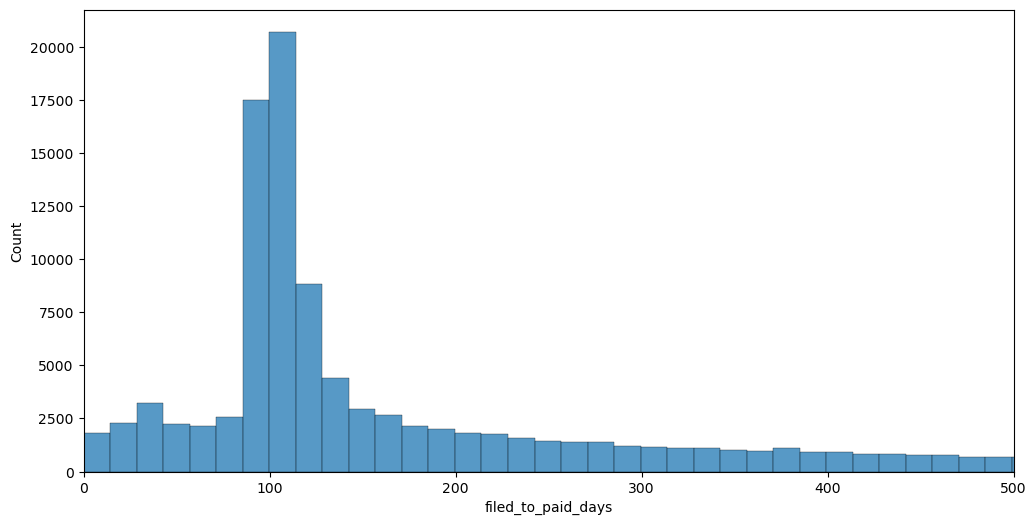

In [61]:
pr["filed_to_paid_days"] = (
    pr["paid_date"] - pr["filed_date"]).dt.days

print(pr["filed_to_paid_days"].describe())

fig = plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=pr,
    x='filed_to_paid_days',
)

ax.set_xlim(0,500)



### Amounts

Negative amounts: 0,  Zero amounts: 775


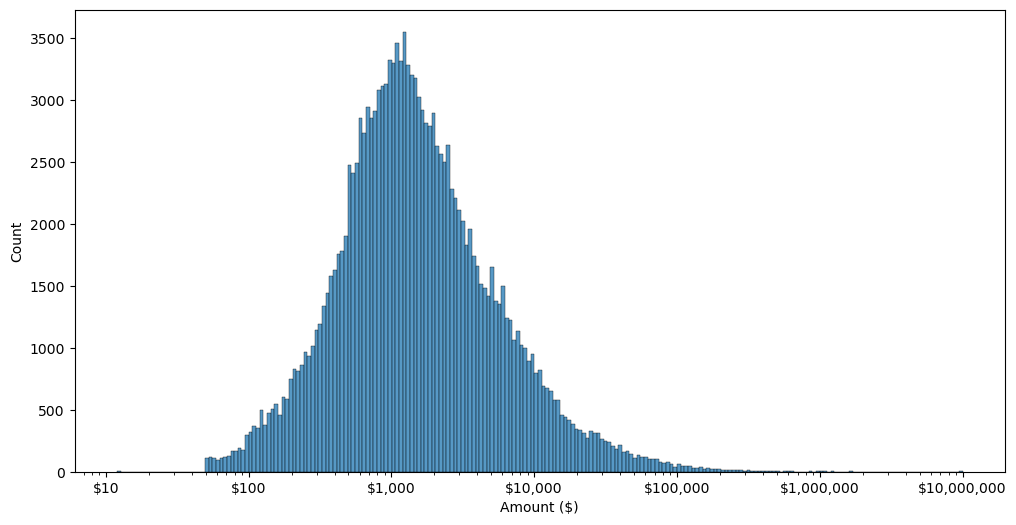

In [62]:
neg_amt  = pr[pr['amount'] < 0]
zero_amt = pr[pr['amount'] == 0]
print(f'Negative amounts: {len(neg_amt)},  Zero amounts: {len(zero_amt)}')

plot_df = pr.loc[pr['amount'] > 0].copy()

fig = plt.figure(figsize=(12, 6))
ax = sns.histplot(
    data=plot_df,
    x='amount',
    log_scale=True
)

ax.xaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
) # format tick labels as dollars
ax.set_xlabel('Amount ($)')
plt.show()

### Customer Claim Counts

In [63]:
pr_counts = pr.groupby('analytics_matchkey').size()
print(pr_counts.describe())

print("Percentage of Customers with more than one claim: ", (pr_counts > 1).mean())
print("Percentage of Customers with more than two claims: ", (pr_counts > 2).mean())

count    134717.000000
mean          1.620456
std           1.321797
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          87.000000
dtype: float64
Percentage of Customers with more than one claim:  0.328006116525754
Percentage of Customers with more than two claims:  0.13928457432989155


### Categorical Counts

/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/var/folders/qn/ym1r3jwd09bd1qv7nhf7c9v40000gn/T/ipykernel_89462/3593652494.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

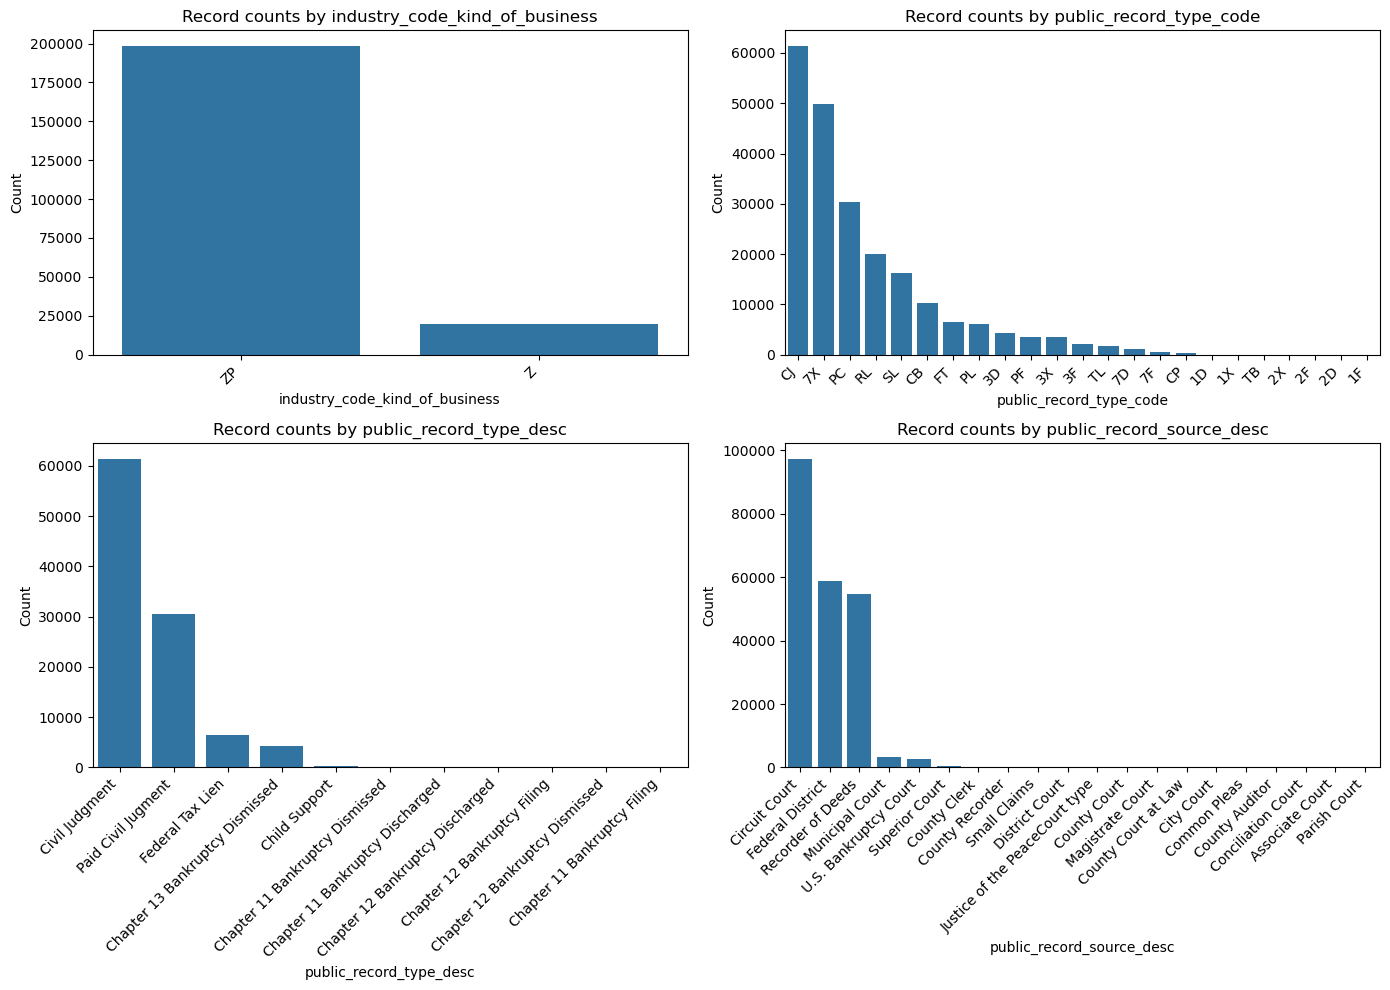

In [64]:
cats = ['industry_code_kind_of_business', 'public_record_type_code', 'public_record_type_desc', 'public_record_source_desc']

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    counts = pr[cat].value_counts(dropna=False)
    sns.barplot(x=counts.index, y=counts.values, ax=ax)
    ax.set_title(f"Record counts by {cat}")
    ax.set_xlabel(cat)
    ax.set_ylabel("Count")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Takeaways
#### Date ordering
- Filed Date ALWAYS Comes First. This makes sense as we wouldnt have data on this unless the claim was filed
- Usually, the debt is paid and then the Reporting org (which in this context would be a bank or court...) will recognize it in their public record system
- Interestingly we have many records of F-E which indicates that the court does not necesarily wait till payment to record the record. It is worth looking at how long they will wait
- There is then a smaller category of "F-E-P" Which could be late payments after the record is made. Will investigate
- F and F-P are interesting because the bank has not "took cognizence" of the record in its files, but we have it here. In this case, somethign must be wrong

#### Payment Speed
- Something happens around day 100 that results in many of these amounts being paid. 

#### Amounts
- Data is Log-Normal
- Would expect this to change depending on claim type. Need to check
- Apparent (almost) hard cutoff at 70 dollars with a few low stragelers. This is weird.
- Why are there 700 0 claims? 

#### Customer Identifier
- Most Customers have only one claim. 32% have 2 or more, 13% have 3 or more

## CrossChecking
Do the diferences above get explained by any other variables

### Claim Amount Distributions by Categorical Variables

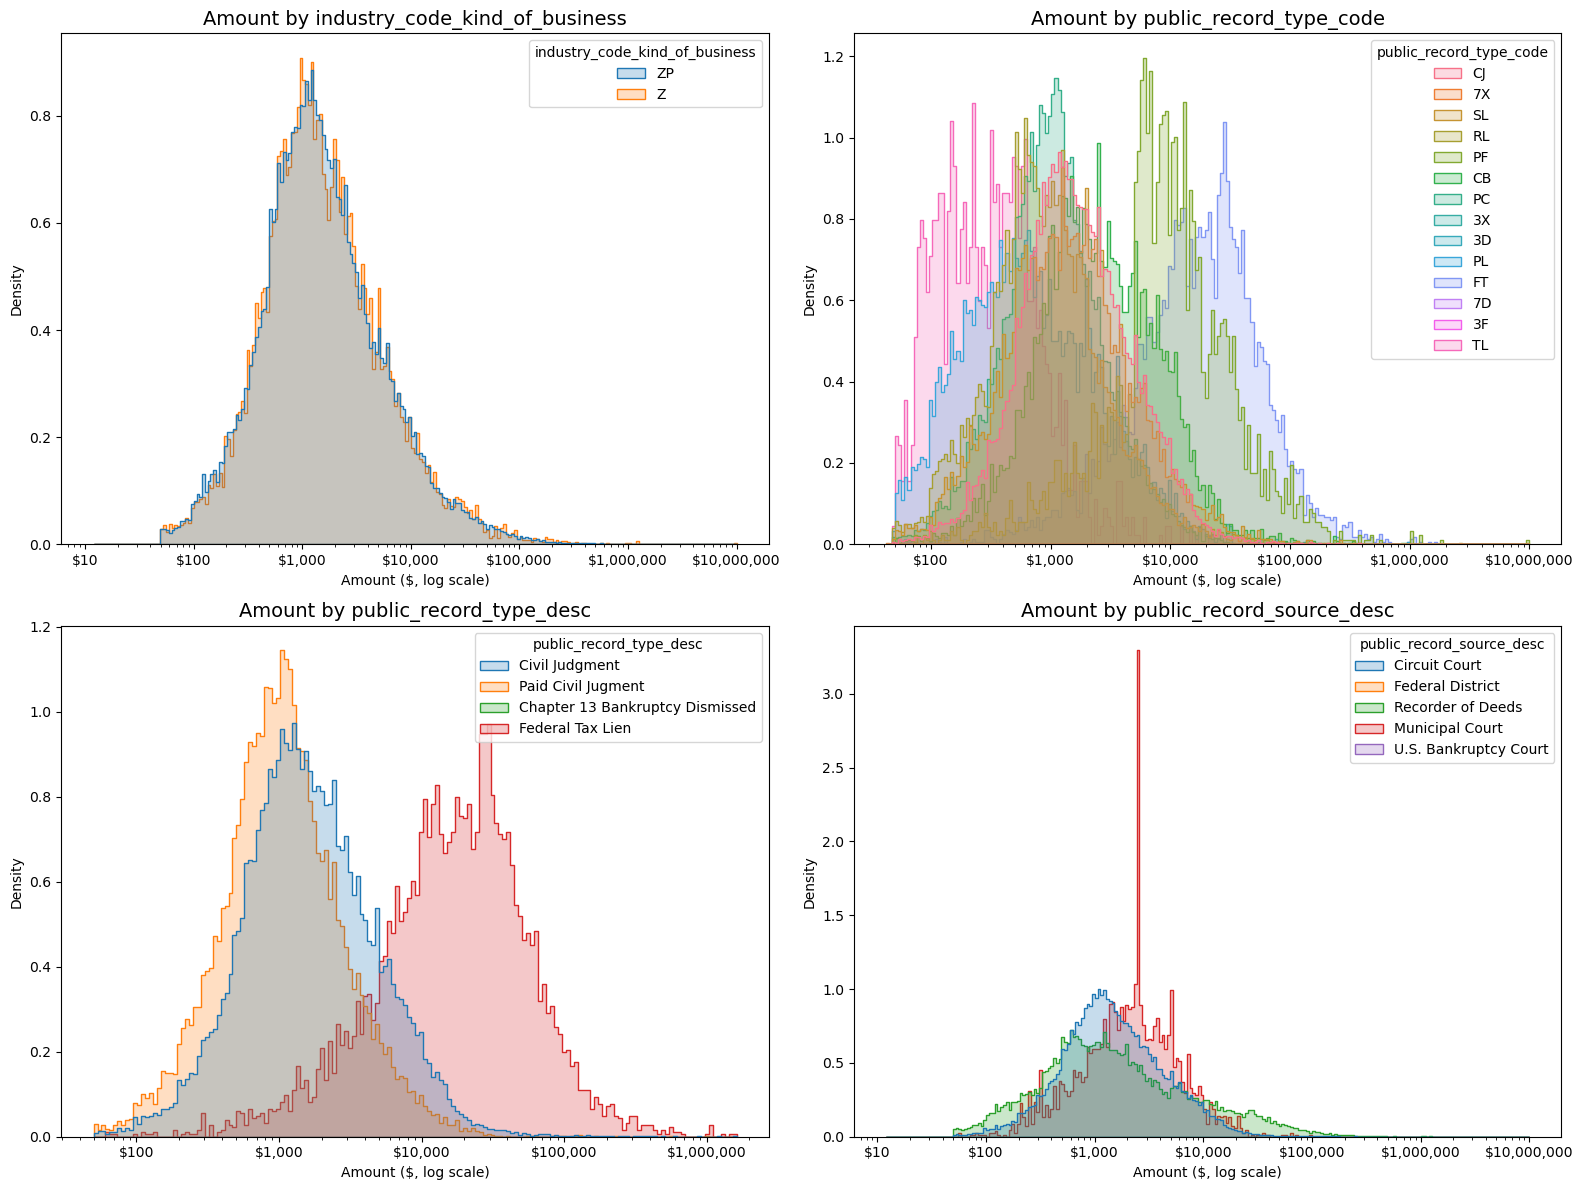

In [ ]:
MIN_COUNT = 500

cats = ['industry_code_kind_of_business', 'public_record_type_code', 'public_record_type_desc', 'public_record_source_desc']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for ax, cat in zip(axes, cats):
    lvl_counts = pr[cat].value_counts()
    valid_lvls = lvl_counts[lvl_counts >= MIN_COUNT].index.tolist()

    # Subset DataFrame
    df_sub = pr[pr[cat].isin(valid_lvls)].copy()

    # Plot histogram with hue
    sns.histplot(
        data=df_sub,
        x="amount",
        hue=cat,
        element="step",
        stat="density",
        common_norm=False,
        ax=ax,
        log_scale=True,
    )
    ax.xaxis.set_major_formatter(
        mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
    )
    
    ax.set_title(f"Amount by {cat}", fontsize=14)
    ax.set_xlabel("Amount ($, log scale)")
    ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

### Does Claim amount change by claim *number* for a given group

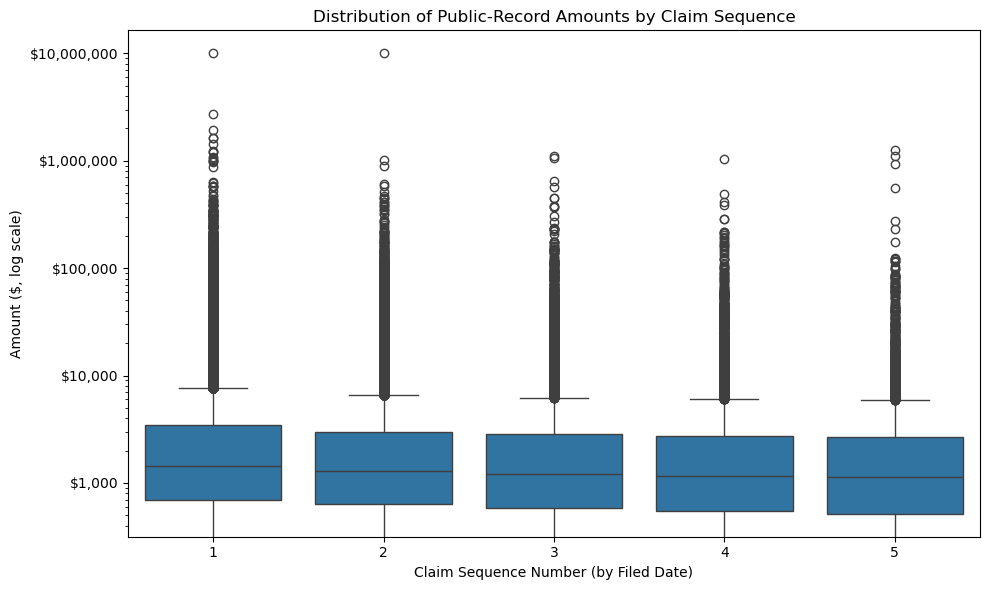

In [76]:
pr_sorted = pr.sort_values(['analytics_matchkey', 'filed_date'])
pr_sorted['claim_num'] = pr_sorted.groupby('analytics_matchkey').cumcount() + 1

df5 = pr_sorted[pr_sorted['claim_num'] <= 5].copy()
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(data=df5, x='claim_num', y='amount', ax=ax)

# Log‐scale the y‐axis for skew
ax.set_yscale('log')

# Format y‐axis ticks as dollars
ax.yaxis.set_major_formatter(
    mtick.FuncFormatter(lambda x, _: f'${x:,.0f}')
)

ax.set_xlabel('Claim Sequence Number (by Filed Date)')
ax.set_ylabel('Amount ($, log scale)')
ax.set_title('Distribution of Public-Record Amounts by Claim Sequence')
plt.tight_layout()
plt.show()